# Data Science Mini Projects 

## Problem 1

*A traveler’s PNR flight data is attached (problem_traveler_raw.xls). For the traveler, in 2018, we want to aggregate total trip spend, total mile count, number of “valid” trips, distinct cities visited. Additionally,  infer the traveler’s home city code and use it to qualify each trip (which is a collection of segments) as round trip or one-way.*

In [173]:
import numpy as np 
import pandas as pd

In [174]:
df=pd.read_csv('problem_traveler_raw.csv')
df.head()

,PNR,origination_city,destination_city,orig_city_cd,dest_city_cd,origination_lat,origination_lon,destination_lat,destination_lon,fl_grfare_usd_am,fl_valid_id,fl_mile_ct,fl_cost_per_mile_usd_am,carry_a2_cd,fl_no,seg_arr_local_time,seg_dprt_local_time,seg_arr_utc_time,seg_dprt_utc_time
0,921597,PHX,MIA,PHX,MIA,33.435036,-112.000164,25.796000,-80.278234,550.95,1,1981,0.27,AA,772,5/14/2018 16:33,5/14/2018 9:03,5/14/2018 23:33,5/14/2018 14:03
1,921597,MIA,PUJ,MIA,PUJ,25.796000,-80.278234,18.562477,-68.363998,252.80,1,909,0.27,AA,2593,5/14/2018 21:23,5/14/2018 19:00,5/15/2018 2:23,5/14/2018 23:00
2,921597,PUJ,MIA,PUJ,MIA,18.562477,-68.363998,25.796000,-80.278234,252.81,1,909,0.27,AA,1317,5/18/2018 9:41,5/18/2018 7:00,5/18/2018 13:41,5/18/2018 12:00
3,921597,MIA,PHX,MIA,PHX,25.796000,-80.278234,33.435036,-112.000164,550.95,1,1981,0.27,AA,272,5/18/2018 15:59,5/18/2018 13:55,5/18/2018 20:59,5/18/2018 20:55
4,492751,PHX,SAN,PHX,SAN,33.435036,-112.000164,32.731938,-117.197312,249.44,1,302,0.82,AA,465,2/5/2018 8:52,2/5/2018 8:35,2/5/2018 15:52,2/5/2018 16:35


In [183]:
df['seg_dprt_local_time'] = pd.to_datetime(df['seg_dprt_local_time'])

# Data for year 2018
df_2018 = df[df['seg_dprt_local_time'].dt.year == 2018].copy()

# Group data by PNR
trip_summary = df_2018.groupby('PNR').agg(
    Total_Trip_Spend=('fl_grfare_usd_am', 'sum'),
    Total_Miles=('fl_mile_ct', 'sum'),
    Valid_Segments=('fl_valid_id', 'sum'),
    Origin_Cities=('orig_city_cd', lambda x: list(x)),
    Dest_Cities=('dest_city_cd', lambda x: list(x))
).reset_index()

# Distinct cities visited
trip_summary['Distinct_Cities_Visited'] = trip_summary.apply(
    lambda row: len(set(row['Origin_Cities'] + row['Dest_Cities'])),
    axis=1)

# Setting home city as origin city with most frequency
home_city = df_2018['orig_city_cd'].value_counts().idxmax()

# Classify trips as round trip or one way
trip_summary['First_Origin'] = trip_summary['Origin_Cities'].apply(lambda x: x[0] if x else None)
trip_summary['Last_Destination'] = trip_summary['Dest_Cities'].apply(lambda x: x[-1] if x else None)
trip_summary['Trip_Type'] = trip_summary.apply(
    lambda row: 'Round Trip' if row['First_Origin'] == home_city and row['Last_Destination'] == home_city else 'One Way',
    axis=1)

print(f"Inferred Home City: {home_city}")
print(f"Trip Type Summary:\n"
      f"{trip_summary['Trip_Type'].value_counts()}")
trip_summary[['PNR', 'Total_Trip_Spend', 'Total_Miles', 'Valid_Segments', 'Distinct_Cities_Visited', 'Trip_Type']].head(10)

Inferred Home City: PHX
Trip Type Summary:
Round Trip    16
One Way        9
Name: Trip_Type, dtype: int64


,PNR,Total_Trip_Spend,Total_Miles,Valid_Segments,Distinct_Cities_Visited,Trip_Type
0,111318,2740.18,6081,4,4,Round Trip
1,252241,1472.43,2131,1,2,One Way
2,276662,4432.92,17565,5,6,Round Trip
3,279194,2413.78,7889,3,5,Round Trip
4,295064,10966.53,5279,1,2,One Way
5,309555,12404.17,18898,4,3,One Way
6,333260,1773.44,3836,2,3,Round Trip
7,335664,10640.98,12991,4,4,Round Trip
8,435290,1208.90,6080,2,3,One Way
9,492751,689.60,906,2,2,Round Trip


The home city (calculated as the origin city with most frequency) is PHX (Phoenix, Arizona). The total number of round trips (trips that start and end at home city) are 16 out of total 25 trips in 2018. 

## Problem 2

*For the dataset “Customer_churn.csv”, develop a predictive model to identify customers who are likely to stop booking through the travel platform (i.e. churn) based on their historical booking behavior over a multi-year period.*

In [230]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [185]:
df=pd.read_csv('Customer_churn.csv')
df.head()

,Customer_ID,Travel_Start_Date,Origin,Destination,Hotel_Spend,Air_Spend,Hotel_Name,Total_Mile,Airline,Cabin,Hotel_Room_Type
0,CUST001,2/16/2021,LAX,DEN,1055.32,883.88,Sheraton,2357,Alaska Air,Business,Luxury
1,CUST001,3/5/2021,SFO,DEN,809.13,438.38,Four Seasons,1169,JetBlue,Business,Deluxe
2,CUST001,4/26/2021,LAX,SFO,467.74,513.75,Holiday Inn,1370,Alaska Air,Business,Suite
3,CUST001,5/17/2021,DFW,ORD,947.01,495.50,Holiday Inn,1982,United,Economy,Standard
4,CUST001,5/30/2021,JFK,ORD,796.41,1333.50,Holiday Inn,2667,American Air,First,Standard


### Preprocessing and Feature Engineering 

To predict churn behaviour, we will deploy an unsupervised clustering algorithm (K-Means) to model customer behaviour based on frequency (total trips), total spend on air and hotel, number of unique destinations visited and recency (days since last booking). Since we are given data till 2024, we will calculate recency from the cutoff date 31st December, 2024.

In [186]:
df['Travel_Start_Date'] = pd.to_datetime(df['Travel_Start_Date'])

# Aggregate features per customer
customer_summary = df.groupby('Customer_ID').agg({
    'Travel_Start_Date': ['max', 'count'],
    'Total_Mile': 'sum',
    'Hotel_Spend': 'sum',
    'Air_Spend': 'sum',
    'Destination': pd.Series.nunique
}).reset_index()

# Rename columns
customer_summary.columns = [
    'Customer_ID', 'Last_Trip_Date', 'Frequency',
    'Total_Miles', 'Total_Hotel_Spend', 'Total_Air_Spend',
    'Unique_Destinations'
]

# Add days since last booking
cutoff = pd.to_datetime('2024-12-31')
customer_summary['Recency'] = (cutoff - customer_summary['Last_Trip_Date']).dt.days

# Drop date column, prepare features
features = customer_summary.drop(columns=['Customer_ID', 'Last_Trip_Date'])

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

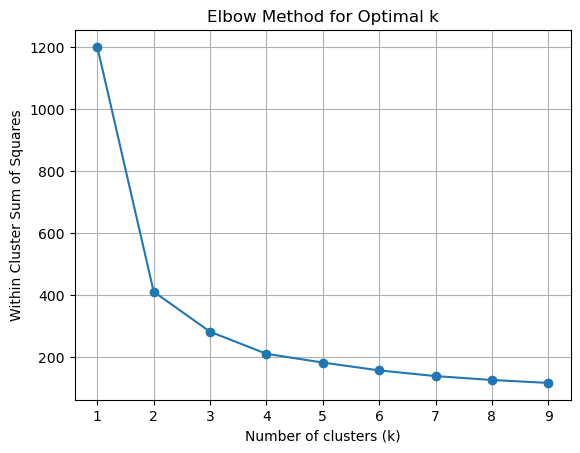

In [190]:
measure = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    measure.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Since the plot sharply changes at k = 2, we will take 2 clusters in our K-means algorithm.

### Modelling and Results

In [194]:
kmeans = KMeans(n_clusters=2, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(X_scaled)

# Show cluster summary stats
cluster_summary = customer_summary.groupby('Cluster').mean(numeric_only=True)
cluster_counts = customer_summary['Cluster'].value_counts().sort_index()
cluster_summary['Count'] = cluster_counts
cluster_summary

,Frequency,Total_Miles,Total_Hotel_Spend,Total_Air_Spend,Unique_Destinations,Recency,Count
Cluster,,,,,,,
0,10.164179,16192.865672,6622.936716,6003.517164,6.731343,144.791045,67
1,29.037594,48344.142857,18144.869474,18206.445338,10.969925,44.721805,133


The two clusters show stark difference in spending and frequency of bookings. 
Cluster 0 seems to be the customers likely to churn, with less total expenditure, less unique cities visited, less frequency of bookings and more days since their last booking.
Cluster 1 indicates active customer base with high spending and high travel frequency with less days on average days since last booking.

*I.	Which customers are the top 5% spenders in total (Air + Hotel), and how many trips do they make on average?*

In [195]:
df['Total_Spend'] = df['Hotel_Spend'] + df['Air_Spend']
grouped_sum = df.groupby('Customer_ID')['Total_Spend'].sum().reset_index()
grouped_sum = grouped_sum.sort_values(by='Total_Spend', ascending=False).head(int(len(grouped_sum)*0.05))

In [196]:
print(grouped_sum)

    Customer_ID  Total_Spend
173     CUST174     54967.16
158     CUST159     54034.53
13      CUST014     51731.66
74      CUST075     51688.53
71      CUST072     51609.14
197     CUST198     51097.38
46      CUST047     49930.82
176     CUST177     48226.87
181     CUST182     47944.09
79      CUST080     47377.20


In [197]:
counts = df['Customer_ID'].value_counts().reset_index()
counts.columns = ['Customer_ID', 'count']
result = pd.merge(grouped_sum, counts, on='Customer_ID', how='left').fillna(0)

print(f"Top 5% spenders make {int(result['count'].mean())} trips on average.")

Top 5% spenders make 37 trips on average.


*II.	Is there a correlation between trip distance (Total_Mile) and total spend per trip?*

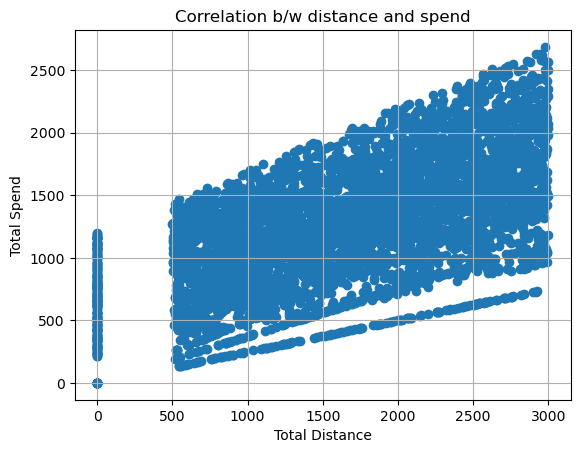

Correlation between total distance and total spend per trip is 0.61. There is a weak positive correlation between them.


In [208]:
correlation = df['Total_Mile'].corr(df['Total_Spend'])
plt.scatter(df['Total_Mile'], df['Total_Spend'])
plt.xlabel('Total Distance')
plt.ylabel('Total Spend')
plt.title('Correlation b/w distance and spend')
plt.grid(True)
plt.show()
print(f"Correlation between total distance and total spend per trip is {correlation:.2f}. There is a weak positive correlation between them.")

*III.	Do premium cabins (Business, First) lead to significantly higher air spend than Economy?*


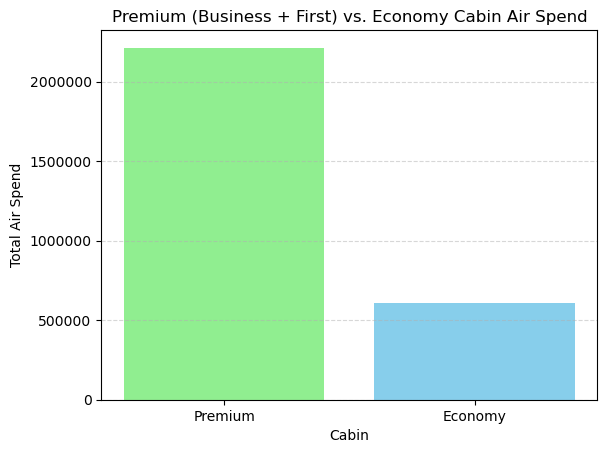

The total premium air spend is 2213391.13 and the total economy air spend is 610301.75.
Total spend on premium cabin is approximately 3 times economy spend.


In [199]:
filtered_df = df[df['Cabin'] != '-']
cabin_sum = filtered_df.groupby('Cabin')['Air_Spend'].sum().reset_index()
premium_total = cabin_sum.loc[0, 'Air_Spend'] + cabin_sum.loc[2, 'Air_Spend']
premium_df = pd.DataFrame({
    'Cabin': ['Premium', cabin_sum.loc[1, 'Cabin']],
    'Air_Spend': [premium_total, cabin_sum.loc[1, 'Air_Spend']]
})

colors = ['lightgreen','skyblue']
plt.bar(premium_df['Cabin'], premium_df['Air_Spend'], color=colors)
plt.xlabel('Cabin')
plt.ylabel('Total Air Spend')
plt.title('Premium (Business + First) vs. Economy Cabin Air Spend')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

print(f"The total premium air spend is {premium_df.loc[0,'Air_Spend']} and the total economy air spend is {premium_df.loc[1,'Air_Spend']}.\n"
      f"Total spend on premium cabin is approximately {int(premium_df.loc[0,'Air_Spend']/premium_df.loc[1,'Air_Spend'])} times economy spend.")

*IV.	How does average total spend per trip vary with trip distance?*

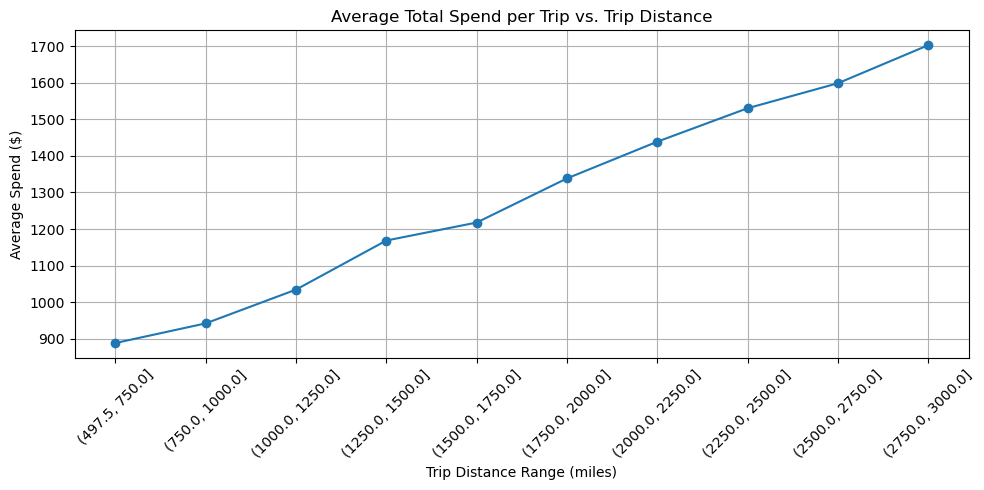

Average total spend per trip almost linearly increases with distance.


In [200]:
dist_df = df[df['Total_Mile'] > 0].copy()
dist_df['distance_bin'] = pd.cut(dist_df['Total_Mile'], bins=10) 
avg_spend = dist_df.groupby('distance_bin')['Total_Spend'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(avg_spend['distance_bin'].astype(str), avg_spend['Total_Spend'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Trip Distance Range (miles)')
plt.ylabel('Average Spend ($)')
plt.title('Average Total Spend per Trip vs. Trip Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Average total spend per trip almost linearly increases with distance.")

*V.	Draw a plot to show trend of total monthly bookings over time.*

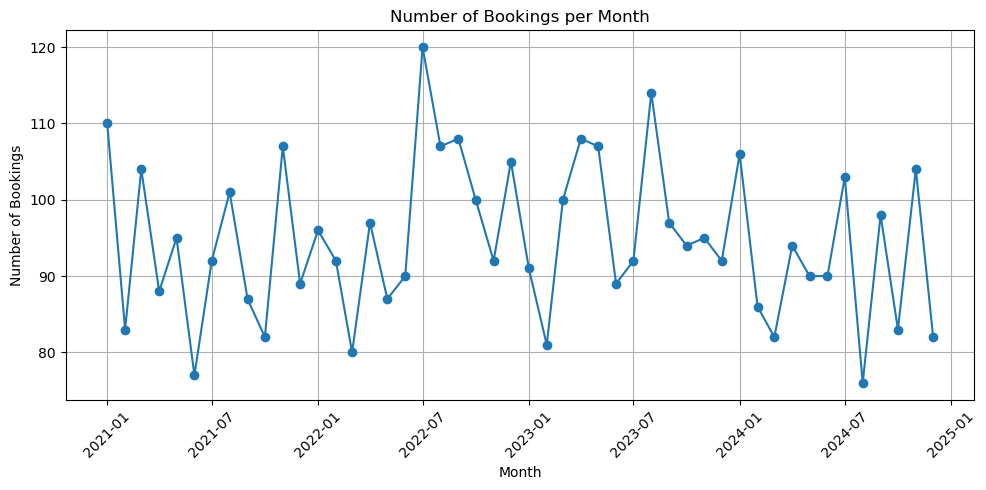

The trend from 2021 to 2024 remains constant.


In [204]:
df['Month'] = df['Travel_Start_Date'].dt.to_period('M')
monthly_trend = df.groupby('Month').size().reset_index(name='Count_Bookings')
monthly_trend['Month'] = monthly_trend['Month'].dt.to_timestamp()

plt.figure(figsize=(10, 5))
plt.plot(monthly_trend['Month'], monthly_trend['Count_Bookings'], marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.title('Number of Bookings per Month')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("The trend from 2021 to 2024 remains constant.")

*VI.	Do univariate and bivariate analysis to find interesting insights from the data.*

Univariate Summary:
       Hotel_Spend    Air_Spend  Total_Spend   Total_Mile
count  4543.000000  4543.000000  4543.000000  4543.000000
mean    628.880564   621.548070  1250.428633  1654.125688
std     342.131626   354.468234   492.001350   805.482035
min       0.000000     0.000000     0.000000     0.000000
25%     368.440000   352.060000   907.055000   998.000000
50%     639.960000   580.000000  1246.150000  1669.000000
75%     914.485000   870.000000  1570.175000  2351.000000
max    1199.190000  1500.000000  2685.730000  3000.000000


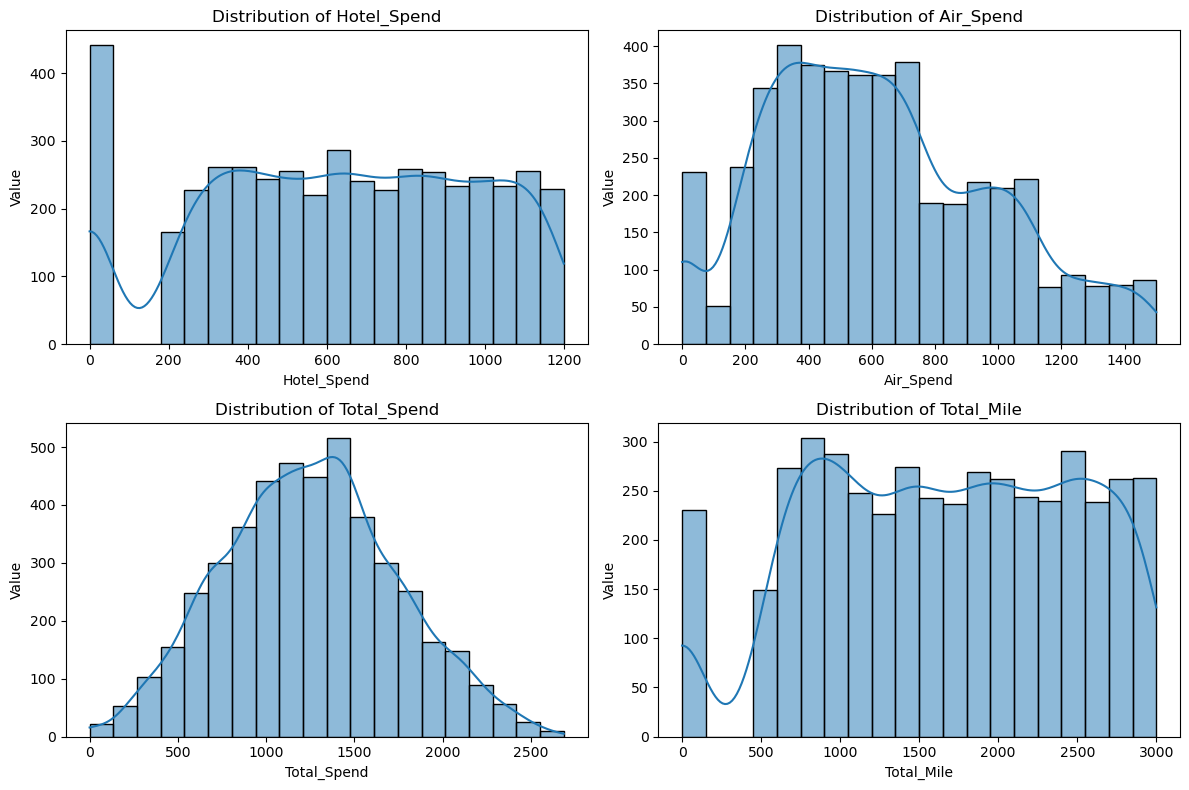


Correlation Matrix:
             Hotel_Spend  Air_Spend  Total_Spend  Total_Mile
Hotel_Spend     1.000000  -0.002624     0.693497   -0.004058
Air_Spend      -0.002624   1.000000     0.718637    0.851207
Total_Spend     0.693497   0.718637     1.000000    0.610440
Total_Mile     -0.004058   0.851207     0.610440    1.000000


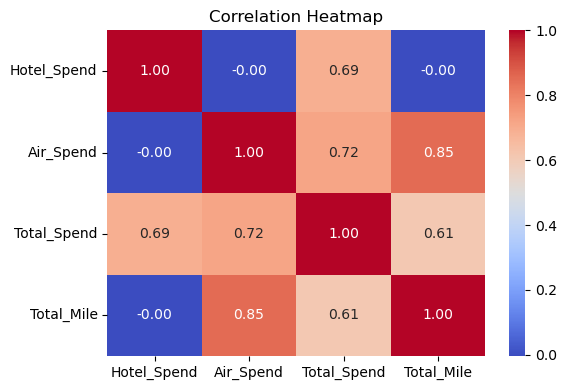

In [229]:
numeric_cols = ['Hotel_Spend', 'Air_Spend', 'Total_Spend', 'Total_Mile']
print("Univariate Summary:\n"
      f"{df[numeric_cols].describe()}")

# Histograms
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=20, kde=True)
    plt.ylabel('Value')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Correlation matrix
corr = df[numeric_cols].corr()
print("\nCorrelation Matrix:")
print(corr)

# Heatmap of correlations
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

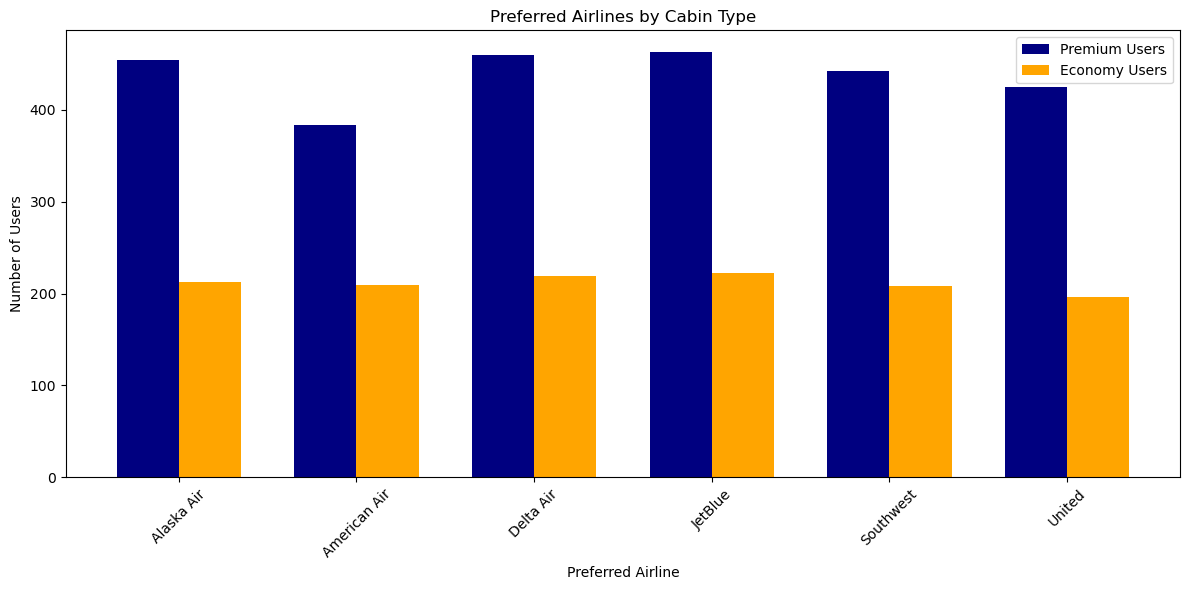

In [246]:
# Combine cabin types
df['Cabin_Grouped'] = df['Cabin'].replace({
    'Business': 'Premium',
    'First': 'Premium',
    'Economy': 'Economy'
})

# Combine hotel room types
df['Hotel_Room_Grouped'] = df['Hotel_Room_Type'].replace({
    'Deluxe': 'Premium',
    'Luxury': 'Premium',
    'Suite': 'Premium',
    'Standard': 'Standard'
})

filtered_df = df[df['Cabin_Grouped'] != '-']
filtered_df = df[df['Hotel_Room_Grouped'] != '-']

premium_df = filtered_df[(filtered_df['Cabin_Grouped'] == 'Premium')]
economy_df = filtered_df[(filtered_df['Cabin_Grouped'] == 'Economy')]

premium_counts = premium_df['Airline'].value_counts()
economy_counts = economy_df['Airline'].value_counts()

all_airlines = sorted(set(premium_counts.index).union(economy_counts.index))
premium_counts = premium_counts.reindex(all_airlines, fill_value=0)
economy_counts = economy_counts.reindex(all_airlines, fill_value=0)

x = np.arange(len(all_airlines))
bar_width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - bar_width/2, premium_counts.values, width=bar_width, label='Premium Users', color='navy')
plt.bar(x + bar_width/2, economy_counts.values, width=bar_width, label='Economy Users', color='orange')

# Add labels and title
plt.xlabel('Preferred Airline')
plt.ylabel('Number of Users')
plt.title('Preferred Airlines by Cabin Type')
plt.xticks(x, all_airlines, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

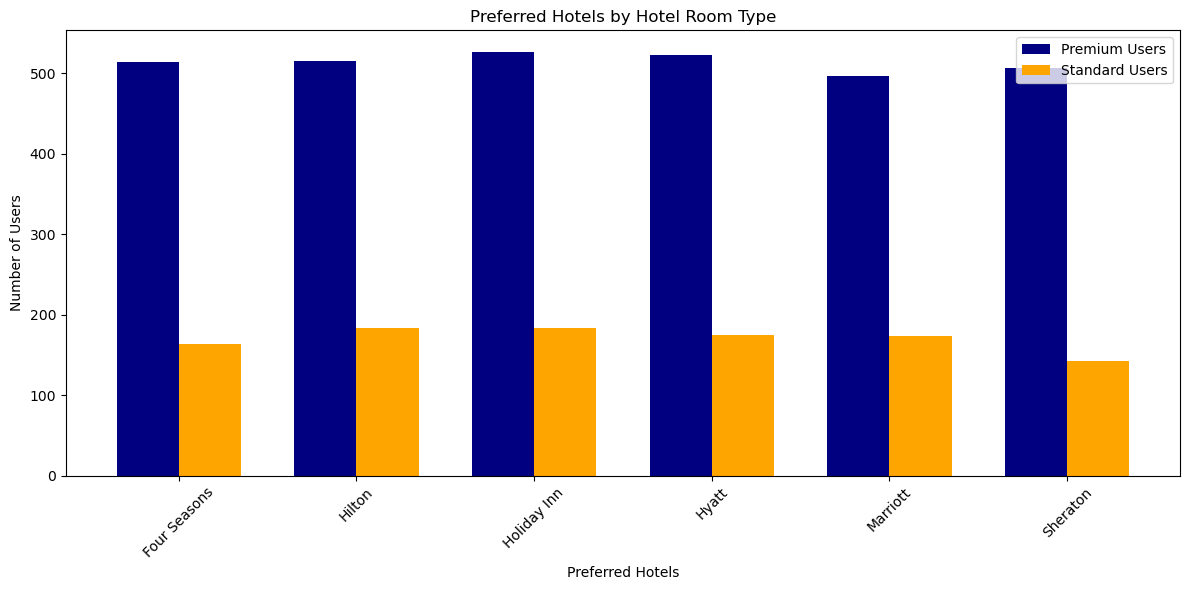

In [249]:
premium_df = filtered_df[(filtered_df['Hotel_Room_Grouped'] == 'Premium')]
economy_df = filtered_df[(filtered_df['Hotel_Room_Grouped'] == 'Standard')]

premium_counts = premium_df['Hotel_Name'].value_counts()
economy_counts = economy_df['Hotel_Name'].value_counts()

all_room = sorted(set(premium_counts.index).union(economy_counts.index))
premium_counts = premium_counts.reindex(all_room, fill_value=0)
economy_counts = economy_counts.reindex(all_room, fill_value=0)

x = np.arange(len(all_room))
bar_width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - bar_width/2, premium_counts.values, width=bar_width, label='Premium Users', color='navy')
plt.bar(x + bar_width/2, economy_counts.values, width=bar_width, label='Standard Users', color='orange')

# Add labels and title
plt.xlabel('Preferred Hotels')
plt.ylabel('Number of Users')
plt.title('Preferred Hotels by Hotel Room Type')
plt.xticks(x, all_room, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

*VII.	Is there a correlation between recency and Churn?*

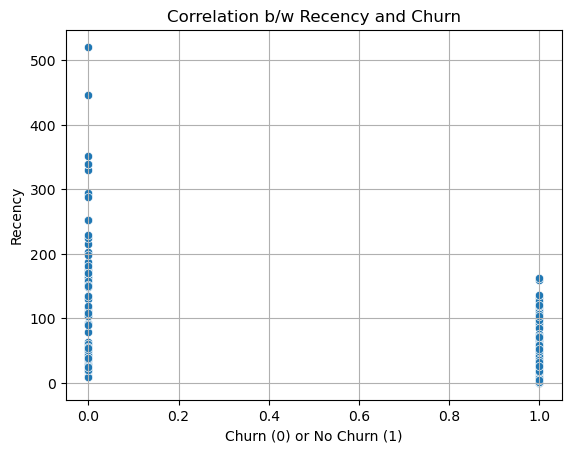

There is a moderate negative correlation of -0.5603932544620196 between recency and churn.


In [215]:
correlation = customer_summary['Recency'].corr(customer_summary['Cluster'])
sns.scatterplot(x='Cluster', y='Recency', data=customer_summary)
plt.xlabel('Churn (0) or No Churn (1)')
plt.ylabel('Recency')
plt.title('Correlation b/w Recency and Churn')
plt.grid(True)
plt.show()
print(f"There is a moderate negative correlation of {correlation} between recency and churn.")

*VIII.	Do most frequent travelers have less propensity to Churn?*

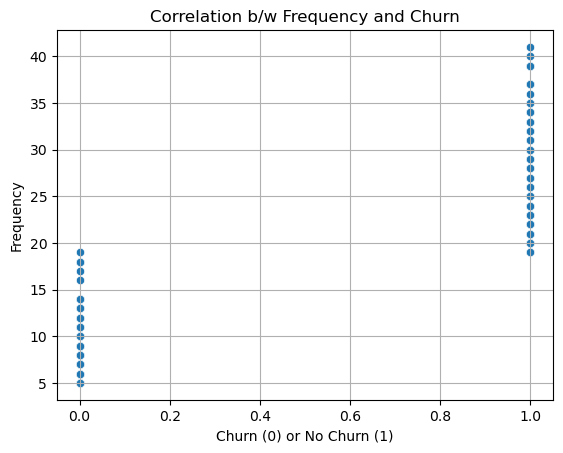

There is a high positive correlation of 0.8704014422462736 between frequency and churn.
It indicates customers with high frequency are less likely to churn


In [218]:
correlation = customer_summary['Frequency'].corr(customer_summary['Cluster'])
sns.scatterplot(x='Cluster', y='Frequency', data=customer_summary)
plt.xlabel('Churn (0) or No Churn (1)')
plt.ylabel('Frequency')
plt.title('Correlation b/w Frequency and Churn')
plt.grid(True)
plt.show()
print(f"There is a high positive correlation of {correlation} between frequency and churn.\n"
      "It indicates customers with high frequency are less likely to churn")

*IX.	What are most common origin-destination pairs?*

In [206]:
df['Origin_Destination'] = df['Origin'] + " + " + df['Destination']
df['Origin_Destination']
top_pairs = df['Origin_Destination'].value_counts().head(10)
print(f"The most common origin-destination pairs are:\n"
      f"{top_pairs}")

The most common origin-destination pairs are:
DFW + ORD    52
MIA + ORD    48
BOS + MIA    46
SEA + DEN    45
SFO + PHX    44
JFK + MIA    44
MIA + LAX    44
DEN + DFW    43
EWR + JFK    42
DFW + SEA    42
Name: Origin_Destination, dtype: int64


*X.	Which customer has the highest lifetime value based on trip frequency and spend?*

In [224]:
customer_summary['Lifetime_Value'] = customer_summary['Frequency'] * (customer_summary['Total_Hotel_Spend'] 
                                                                      + customer_summary['Total_Air_Spend'])

top_customer = customer_summary.loc[customer_summary['Lifetime_Value'].idxmax()]

print("Customer with Highest Lifetime Value:\n"
      f"{top_customer[['Customer_ID', 'Lifetime_Value']]}")

Customer with Highest Lifetime Value:
Customer_ID          CUST174
Lifetime_Value    2253653.56
Name: 173, dtype: object


Note: Lifetime value calculated as the total revenue generated by a customer = frequency * (total spend).

*XI.	Most frequent airlines and most frequently booked hotels.*

In [121]:
filtered_df = df[df['Airline'] != '-']
top_airlines = filtered_df['Airline'].value_counts()
print(top_airlines)

JetBlue         758
Delta Air       758
Alaska Air      735
Southwest       714
American Air    676
United          671
Name: Airline, dtype: int64


In [122]:
filtered_df = df[df['Hotel_Name'] != '-']
top_hotels = filtered_df['Hotel_Name'].value_counts()
print(top_hotels)

Holiday Inn     710
Hyatt           698
Hilton          698
Four Seasons    677
Marriott        670
Sheraton        649
Name: Hotel_Name, dtype: int64


*XII.	Do you have any suggestions to prevent the customers which are likely to churn?*

1) The customers likely to churn are low on frequency and spend, it will be most helpful to initiate deals or incentives in terms of discounts and bundled coupons to attract them to the platform. 
2) Early detection and monitoring of drop in number of bookings, to mitigate churn effect. 
3) Reward highly active customers with VIP membership or loyalty programs. 
4) Focus on customer segmentation and analysis to understand preferences based on spending, frequency and duration of travel and giving personalised recommendations.
5) Study competitor and market behaviour for new trends.  